In [ ]:
import nest_asyncio
nest_asyncio.apply()

%matplotlib inline  
import matplotlib.pyplot as plt
from mutabledataset import SimpleDataset
from agent import RationalAgent
from simulation import Simulation
from learner import LogisticLearner
import plot
import numpy as np
from learner import StatisticalParityLogisticLearner, StatisticalParityFlipperLogisticLearner
from learner import FairLearnLearner
from learner import RejectOptionsLogisticLearner
from learner import ReweighingLogisticLearner
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import seaborn as sns

mutable_attr = 'x'
def do_sim(learner, avg_out_incentive=50):
    cost_lambda = lambda x_new, x:  1*abs(x_new-x)/4. + 3*pow(x_new, 2.)/4.
    cost_fixed = lambda size: np.abs(np.random.normal(loc=0.5,scale=0.5,size=size))


    g = SimpleDataset(mutable_features=['x'],
            domains={'x': 'auto'},
            discrete=['x'],
            cost_fns={'x': cost_lambda})

    sim = Simulation(g,
                     RationalAgent,
                     learner,
                     cost_fixed,
                     collect_incentive_data=True, avg_out_incentive=avg_out_incentive, no_neighbors=11)

    result_set = sim.start_simulation(runs=1)
    return result_set

def print_stats(result_set, name):
    print(result_set)
    print("StatPar Δ:", round(result_set.stat_parity_diff({'group': 0}, {'group': 1}),2))
    pre_up_mean, pre_up_std, post_up_mean, post_up_std = tuple(map(lambda x: round(x,2),result_set.feature_average(mutable_attr, {'group':0})))
    pre_p_mean, pre_p_std, post_p_mean, post_p_std = tuple(map(lambda x: round(x,2),result_set.feature_average(mutable_attr, {'group':1})))
    diff = abs(post_up_mean - post_p_mean)
    diff_pre = abs(pre_up_mean - pre_p_mean)
    print("Feature x (mean):")
    print("(UP) Pre :", pre_up_mean, "(+-", pre_up_std, ")")
    print("(P) Pre  :", pre_p_mean, "(+-", pre_p_std, ")")
    print("(UP) Post:", post_up_mean, "(+-", post_up_std, ")")
    print("(P) Post :", post_p_mean, "(+-", post_p_std, ")")
    display(Markdown("**Feature x average Δ (post):** " + str(round(diff, 2))))
    display(Markdown("**Feature x average Δ (pre):** " + str(round(diff_pre, 2))))
    
    sns.set()
    plt.figure(name)
    
    #ax = sns.lineplot(x=mutable_attr, y="incentive",hue='uid',data=(rs._avg_incentive(mutable_attr, 'uid')).reset_index(), legend=False)
    ax = sns.lineplot(x=mutable_attr, y="incentive",hue='group',data=(rs._avg_incentive(mutable_attr, 'group')).reset_index())
    #plt.savefig(name+".png")
    plt.show()



privileged_groups = [{'group': 1}]
unprivileged_groups = [{'group': 0}]

# Setup / Model
## Simple Dataset Distribution

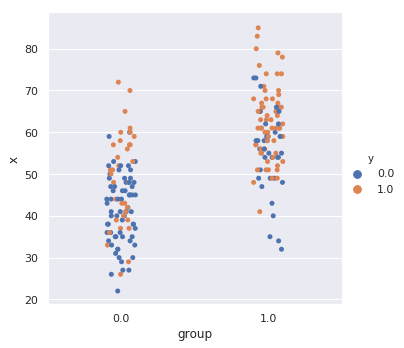

In [8]:
g = SimpleDataset(mutable_features=['x'],
        domains={'x': 'auto'},
        discrete=['x'],
        cost_fns={})
sns.catplot(x="group", y="x", hue="y", data=g.convert_to_dataframe()[0]);

# Random flip: effect of averaging incentive

(100, 2) (100, 2)
2.0  before:  85.0


## No averaging

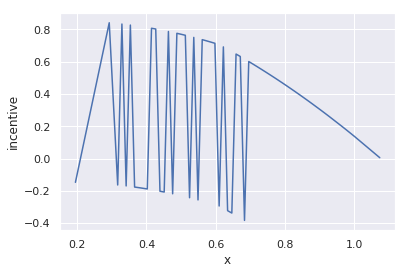

(100, 2) (100, 2)
1.0  before:  90.0


## Averaging (50 each)

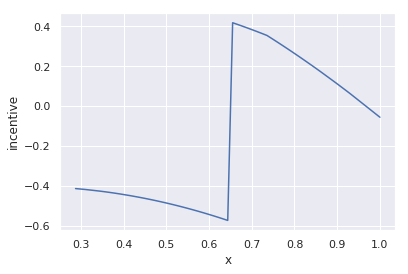

In [20]:
rs = do_sim(StatisticalParityFlipperLogisticLearner(privileged_groups, unprivileged_groups, exclude_protected=True), avg_out_incentive=1)
data = (rs._avg_incentive('x', 'uid')).reset_index()
uids = list(set(rs._avg_incentive('x', 'uid').reset_index()['uid']))
uid = np.random.choice(uids)

display(Markdown("## No averaging"))
ax = sns.lineplot(x='x', y="incentive",hue='uid',data=data[data['uid'] == uid], legend=False)
plt.show()

rs = do_sim(StatisticalParityFlipperLogisticLearner(privileged_groups, unprivileged_groups, exclude_protected=True), avg_out_incentive=50)
data = (rs._avg_incentive('x', 'uid')).reset_index()
uids = list(set(rs._avg_incentive('x', 'uid').reset_index()['uid']))
uid = np.random.choice(uids)

display(Markdown("## Averaging (50 each)"))
ax = sns.lineplot(x='x', y="incentive",hue='uid',data=data[data['uid'] == uid], legend=False)
plt.show()


# Random flip vs. "score sensitive"

### DIY random-flipper (w. averaging)

(100, 2) (100, 2)
4.0  before:  88.0
Runs:  1 
 Eps:  0.02  (+-  0.0 ) 
 Acc h:  0.28  (+-  0.0 ) 

StatPar Δ: 0.0
Feature x (mean):
(UP) Pre : 0.56 (+- 0.0 )
(P) Pre  : 0.76 (+- 0.0 )
(UP) Post: 0.65 (+- 0.0 )
(P) Post : 0.76 (+- 0.0 )


**Feature x average Δ (post):** 0.11

**Feature x average Δ (pre):** 0.2

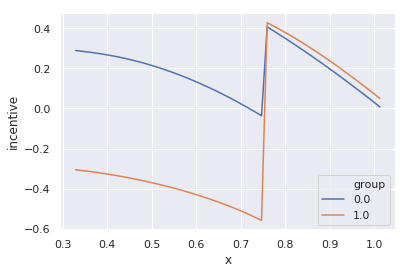

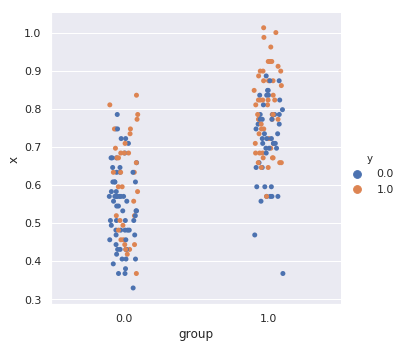

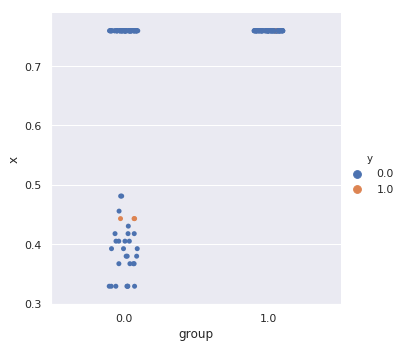

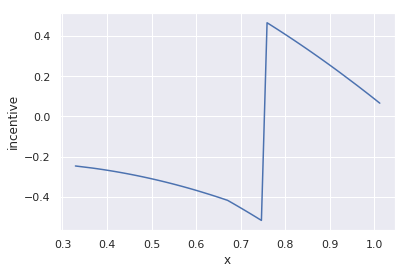

### DIY random-flipper (w/o averaging)

(100, 2) (100, 2)
2.0  before:  98.0
Runs:  1 
 Eps:  0.0  (+-  0.0 ) 
 Acc h:  0.4  (+-  0.0 ) 

StatPar Δ: -0.4
Feature x (mean):
(UP) Pre : 0.51 (+- 0.0 )
(P) Pre  : 0.7 (+- 0.0 )
(UP) Post: 0.19 (+- 0.0 )
(P) Post : 0.59 (+- 0.0 )


**Feature x average Δ (post):** 0.4

**Feature x average Δ (pre):** 0.19

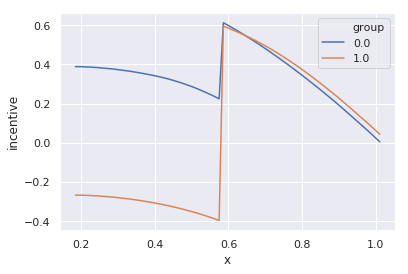

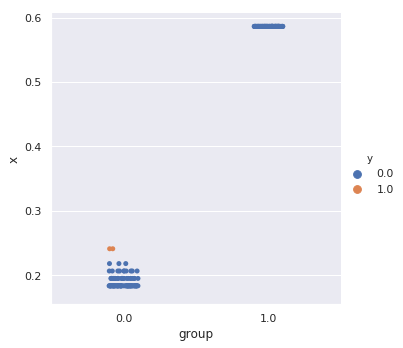

### DIY Booster (post-process)

(100, 2) (100, 2)
3.0  before:  91.0
Runs:  1 
 Eps:  0.02  (+-  0.0 ) 
 Acc h:  0.33  (+-  0.0 ) 

StatPar Δ: 0.0
Feature x (mean):
(UP) Pre : 0.55 (+- 0.0 )
(P) Pre  : 0.7 (+- 0.0 )
(UP) Post: 0.51 (+- 0.0 )
(P) Post : 0.68 (+- 0.0 )


**Feature x average Δ (post):** 0.17

**Feature x average Δ (pre):** 0.15

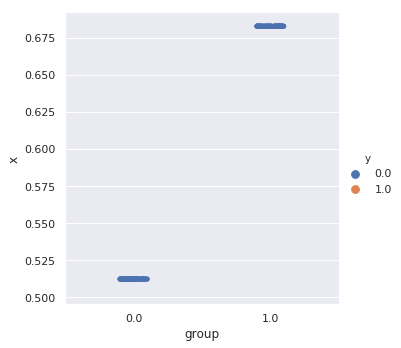

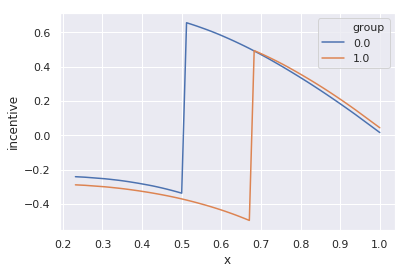

In [21]:
display(Markdown("### DIY random-flipper (w. averaging)"))
rs = do_sim(StatisticalParityFlipperLogisticLearner(privileged_groups, unprivileged_groups, exclude_protected=True))
print_stats(rs, "postFlipperDIY")
sns.catplot(x="group", y="x", hue="y", data=rs.results[0].df)
plt.show()

sns.catplot(x="group", y="x", hue="y", data=rs.results[0].df_new)
plt.show()

data = (rs._avg_incentive('x', 'uid')).reset_index()
uids = list(set(rs._avg_incentive('x', 'uid').reset_index()['uid']))
uid = np.random.choice(uids)
ax = sns.lineplot(x='x', y="incentive",hue='uid',data=data[data['uid'] == uid], legend=False)
plt.show()
exit(1)

display(Markdown("### DIY random-flipper (w/o averaging)"))
rs = do_sim(StatisticalParityFlipperLogisticLearner(privileged_groups, unprivileged_groups, exclude_protected=True), avg_out_incentive=1)
print_stats(rs, "postFlipperDIY")
sns.catplot(x="group", y="x", hue="y", data=rs.results[0].df_new)
plt.show()

display(Markdown("### DIY Booster (post-process)"))
rs = do_sim(StatisticalParityLogisticLearner(privileged_groups, unprivileged_groups, eps=0.001))
sns.catplot(x="group", y="x", hue="y", data=rs.results[0].df_new)
print_stats(rs, "postDIY")